In [1]:
using BenchmarkTools
using Unrolled

using SIMD

using ChipSort

In [2]:
function chipsort_merge_2_chunks(data::Array{T, 1}, ::Val{N}) where {T, N}
    Nchunks = 2
    chunk_size = div(length(data), Nchunks)

    output2 = valloc(T, div(32, sizeof(T)), length(data))

    p1 = 1
    p2 = 1 + chunk_size
    h1 = vload(Vec{N, T}, data, p1)
    h2 = vload(Vec{N, T}, data, p2)

    pout = 1
    out, state = bitonic_merge(h1, h2)

    vstorent(out, output2, pout)
    pout+=N

    end1 = chunk_size+1
    end2 = chunk_size*2+1
    p1 += N
    p2 += N
    h1 = vload(Vec{N, T}, data, p1)
    h2 = vload(Vec{N, T}, data, p2)
    while p1 < end1 || p2 < end2
        if p2 >= end2 || ((p1 < end1) && (h1[1] < h2[1]))
            out, state = bitonic_merge(state, h1)
            if p1 < end1
                p1 += N
                h1 = vload(Vec{N, T}, data, p1)
            end
        else
            out, state = bitonic_merge(state, h2)
            if p2 < end2
                p2 += N
                h2 = vload(Vec{N, T}, data, p2)
            end
        end
        vstorent(out, output2, pout)
        pout+=N
    end
    vstorent(state, output2, pout)
    output2
end

data=rand(Int32, 2^11)
sort!(@view data[1:div(end,2)])
sort!(@view data[1+div(end,2):end])
@assert chipsort_merge_2_chunks(data, Val(4)) == sort(data)

In [3]:
function two_chunks(T, data_size)
    data = rand(T, data_size)
    sort!(data[1:div(end,2)])
    sort!(data[1+div(end,2):end])
    data
end

function run_bench_mine(T, data_size, nn::Val{N}) where {N}
    data = two_chunks(T, data_size)
    stat = @benchmark chipsort_merge_2_chunks($data, $nn)
    stat
end

#function run_bench_base(T, data_size, ::Val{N}, ::Val{L}) where {N, L}
#    data = two_chunks(T, data_size)
#    stat = @benchmark baseline_merge($data)
#    stat
#end

run_bench_mine (generic function with 1 method)

In [6]:
struct ExpRun
    code
    eltype
    data_size
    vec_size
    vec_count
    bench
end

function Base.show(io::IO, ee::ExpRun)
    print(ee.code, " ")
    print(ee.eltype, " ")
    print(ee.data_size, " ")
    print(ee.vec_size, " ")
    print(ee.vec_count, " ")
    print(ee.bench.times[div(end,2)])
end

@unroll function run_tests(data_size, nn)
    exps = ExpRun[]
    T = Float32
    @unroll for n in nn
        tt = run_bench_mine(T, data_size, Val(n))
        ee = ExpRun(:chip, T, data_size, n, 0, tt)
        println(ee)
        push!(exps, ee)
#        tt = run_bench_base(T, data_size, Val(n))
#        ee = ExpRun(:juli, T, data_size, n, l, tt)
#        println(ee)
#        push!(exps, ee)
    end
    exps
end

chunk_sizes = (1,2,4,8,16,32,64,128,256,512)

data = run_tests(2^14, chunk_sizes)

chip Float32 16384 1 0 46471.0
chip Float32 16384 2 0 47105.0
chip Float32 16384 4 0 37635.0
chip Float32 16384 8 0 32048.0
chip Float32 16384 16 0 22656.0
chip Float32 16384 32 0 19561.0
chip Float32 16384 64 0 18317.0
chip Float32 16384 128 0 21465.0
chip Float32 16384 256 0 26021.0
chip Float32 16384 512 0 30224.0


10-element Array{ExpRun,1}:
 
 
 
 
 
 
 
 
 
 

chip Float32 16384 1 0 46471.0chip Float32 16384 2 0 47105.0chip Float32 16384 4 0 37635.0chip Float32 16384 8 0 32048.0chip Float32 16384 16 0 22656.0chip Float32 16384 32 0 19561.0chip Float32 16384 64 0 18317.0chip Float32 16384 128 0 21465.0chip Float32 16384 256 0 26021.0chip Float32 16384 512 0 30224.0chip Float32 16384 1 0 46471.0chip Float32 16384 1 0 46471.0chip Float32 16384 2 0 47105.0chip Float32 16384 2 0 47105.0chip Float32 16384 4 0 37635.0chip Float32 16384 4 0 37635.0chip Float32 16384 8 0 32048.0chip Float32 16384 8 0 32048.0chip Float32 16384 16 0 22656.0chip Float32 16384 16 0 22656.0chip Float32 16384 32 0 19561.0chip Float32 16384 32 0 19561.0chip Float32 16384 64 0 18317.0chip Float32 16384 64 0 18317.0chip Float32 16384 128 0 21465.0chip Float32 16384 128 0 21465.0chip Float32 16384 256 0 26021.0chip Float32 16384 256 0 26021.0chip Float32 16384 512 0 30224.0chip Float32 16384 512 0 30224.0

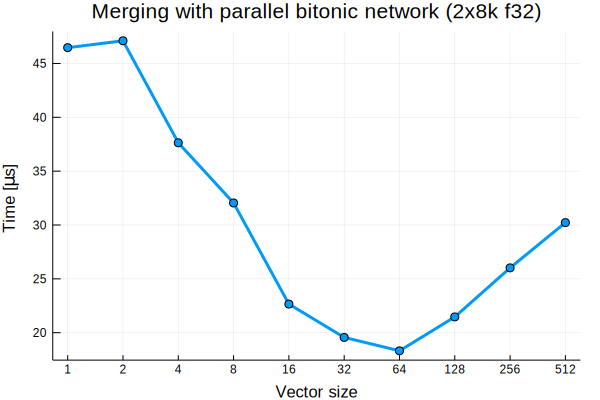

In [40]:
using LaTeXStrings, Plots

ch = [1e-3*ee.bench.times[div(end,2)] for ee in data]

plot(
    title="Merging with parallel bitonic network (2x8k f32)",
    xticks=(1:10, 2 .^ (0:9)),
    xlabel="Vector size",
    ylabel=("Time [\\mu s]")
)
plot!(ch, m=:circ,label="", l=3)